### 任务1:微调在ImageNet上预训练的卷积神经网络实现鸟类识别

下面是使用PyTorch实现在ImageNet上预训练的ResNet-18模型进行鸟类识别的代码示例：

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torch.utils.tensorboard import SummaryWriter

In [12]:
#加载数据集
from dataset_image import CUB
import transforms
from torch.utils.data import DataLoader
import time

time1 = time.time()
IMAGE_SIZE = 448
TRAIN_MEAN = [0.48560741861744905, 0.49941626449353244, 0.43237713785804116]
TRAIN_STD = [0.2321024260764962, 0.22770540015765814, 0.2665100547329813]
TEST_MEAN = [0.4862169586881995, 0.4998156522834164, 0.4311430419332438]
TEST_STD = [0.23264268069040475, 0.22781080253662814, 0.26667253517177186]

path = 'CUB_200_2011/CUB_200_2011'
train_transforms = transforms.Compose([
        transforms.ToCVImage(),
        transforms.RandomResizedCrop(IMAGE_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(TRAIN_MEAN, TRAIN_STD)
    ])

test_transforms = transforms.Compose([
    transforms.ToCVImage(),
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(TEST_MEAN,TEST_STD)
    ])

train_dataset = CUB(
        path,
        train=True,
        transform=train_transforms,
        target_transform=None
    )
    # print(len(train_dataset))
train_dataloader = DataLoader(
    train_dataset,
    batch_size=16,
    num_workers=4,
    shuffle=True
)

test_dataset = CUB(
        path,
        train=False,
        transform=test_transforms,
        target_transform=None
    )

test_dataloader = DataLoader(
    test_dataset,
    batch_size=16,
    num_workers=4,
    shuffle=True
)

time2 = time.time()

print(time2-time1)
train_len = train_dataset.__len__()
test_len = test_dataset.__len__()


0.04039716720581055


### 无预训练的参数初始化

In [13]:
# 在随机初始化参数的情况下训练模型进行对比
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18()
num_ftrs = model.fc.in_features
print(num_ftrs)
model.fc = nn.Linear(num_ftrs, 200)
model = model.to(device)

512


### tensorboard可视化过程

In [ ]:
# 定义损失函数和优化器
## 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# 训练模型
num_epochs = 25
writer = SummaryWriter()
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)

    for phase in ['train', 'val']:
        if phase == 'train':
            dataloader=train_dataloader
            data_len=train_len
            model.train()
        else:
            dataloader=test_dataloader
            data_len=test_len
            model.eval()
        
        #dataloader=train_dataloader
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / data_len
        epoch_acc = running_corrects.double() / data_len

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        if phase == 'train':
            writer.add_scalar('Loss/train', epoch_loss, epoch)
            writer.add_scalar('Accuracy/train', epoch_acc, epoch)
        else:
            writer.add_scalar('Loss/val', epoch_loss, epoch)
            writer.add_scalar('Accuracy/val', epoch_acc, epoch)

writer.close()

### matplotlib可视化过程

Epoch 1/30
----------
train Loss: 5.2944 Acc: 0.0077
val Loss: 5.2136 Acc: 0.0154
Epoch 2/30
----------
train Loss: 5.0595 Acc: 0.0158
val Loss: 5.0027 Acc: 0.0224
Epoch 3/30
----------
train Loss: 4.8914 Acc: 0.0244
val Loss: 4.9069 Acc: 0.0259
Epoch 4/30
----------
train Loss: 4.7650 Acc: 0.0357
val Loss: 4.8632 Acc: 0.0357
Epoch 5/30
----------
train Loss: 4.6967 Acc: 0.0384
val Loss: 4.9335 Acc: 0.0437
Epoch 6/30
----------
train Loss: 4.6130 Acc: 0.0517
val Loss: 4.8906 Acc: 0.0461
Epoch 7/30
----------
train Loss: 4.5545 Acc: 0.0547
val Loss: 4.8406 Acc: 0.0504
Epoch 8/30
----------
train Loss: 4.5069 Acc: 0.0591
val Loss: 4.6365 Acc: 0.0532
Epoch 9/30
----------
train Loss: 4.4344 Acc: 0.0701
val Loss: 4.5962 Acc: 0.0618
Epoch 10/30
----------
train Loss: 4.3436 Acc: 0.0749
val Loss: 4.6533 Acc: 0.0635
Epoch 11/30
----------
train Loss: 4.3145 Acc: 0.0806
val Loss: 4.5747 Acc: 0.0666
Epoch 12/30
----------
train Loss: 4.2218 Acc: 0.0911
val Loss: 4.5754 Acc: 0.0678
Epoch 13/30
-

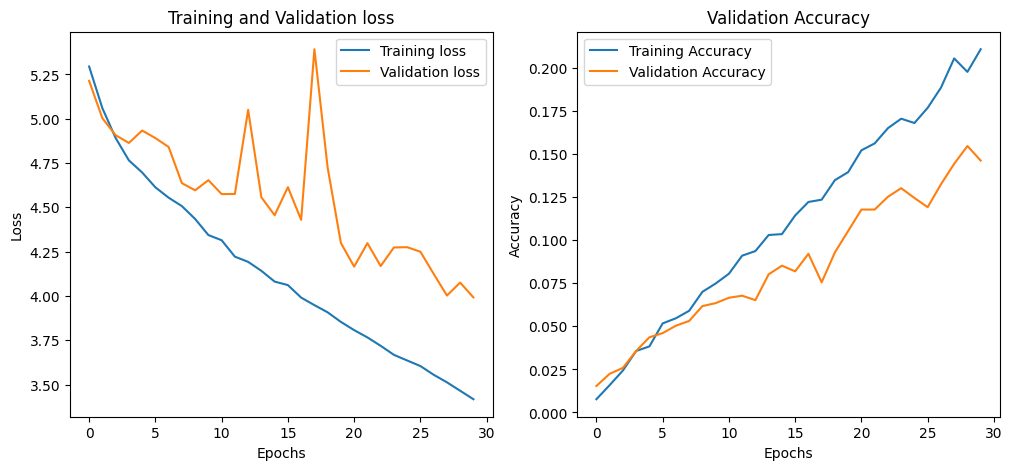

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

# 假设 model, train_dataloader, test_dataloader 已经定义好了
# 定义损失函数和优化器
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model = model_random  # 确保你的模型已经定义为 'model_random'
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# 初始化变量用于存储损失和精度数据
train_losses, train_accuracies,val_losses, val_accuracies = [],[], [], []

# 训练模型
num_epochs = 30
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)

    for phase in ['train', 'val']:
        if phase == 'train':
            dataloader = train_dataloader
            data_len = len(dataloader.dataset)
            model.train()
        else:
            dataloader = test_dataloader
            data_len = len(dataloader.dataset)
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / data_len
        epoch_acc = (running_corrects.double() / data_len).cpu().item()

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        if phase == 'train':
            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_acc)
        else:
            val_losses.append(epoch_loss)
            val_accuracies.append(epoch_acc)

# 绘制损失和精度图
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()